# 00 — Data Exploration
**Smart-Lite Insight: UCI Household Electric Power Consumption**

This notebook explores the UCI dataset loaded into our SQLite database. We'll examine:
1. Data shape, types, and basic statistics
2. Missing data patterns
3. Daily and weekly consumption profiles
4. Distributions of key metrics
5. Correlations between variables
6. Identification of natural anomalies for manual labelling

In [5]:
import sqlite3
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Notebook display settings
pd.set_option("display.max_columns", 15)
pd.set_option("display.float_format", "{:.3f}".format)
plt.rcParams["figure.figsize"] = (14, 5)
plt.rcParams["figure.dpi"] = 100
plt.style.use("seaborn-v0_8-whitegrid")

DB_PATH = "../data/processed/energy.db"
print(f"Database: {Path(DB_PATH).resolve()}")

Database: C:\Users\babatundea\Documents\smart-lite-insight\data\processed\energy.db


## 1. Load Data from SQLite

We load only the **UCI real data** (`site_id = 'home-01'`), excluding synthetic data.

In [6]:
conn = sqlite3.connect(DB_PATH)

df = pd.read_sql_query(
    """
    SELECT
        timestamp,
        global_active_power_kw,
        global_reactive_power_kw,
        voltage_v,
        global_intensity_a,
        sub_metering_1_wh,
        sub_metering_2_wh,
        sub_metering_3_wh
    FROM readings
    WHERE site_id = 'home-01'
    ORDER BY timestamp
    """,
    conn,
    parse_dates=["timestamp"],
)
conn.close()

df = df.set_index("timestamp")
print(f"Shape: {df.shape}")
print(f"Date range: {df.index.min()} to {df.index.max()}")
print(f"Duration: {(df.index.max() - df.index.min()).days} days")

Shape: (2049280, 7)
Date range: 2006-12-16 17:24:00 to 2010-11-26 21:02:00
Duration: 1441 days


## 2. Basic Statistics

First look at the data — types, distributions, and obvious issues.

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2049280 entries, 2006-12-16 17:24:00 to 2010-11-26 21:02:00
Data columns (total 7 columns):
 #   Column                    Dtype  
---  ------                    -----  
 0   global_active_power_kw    float64
 1   global_reactive_power_kw  float64
 2   voltage_v                 float64
 3   global_intensity_a        float64
 4   sub_metering_1_wh         float64
 5   sub_metering_2_wh         float64
 6   sub_metering_3_wh         float64
dtypes: float64(7)
memory usage: 125.1 MB


In [8]:
df.describe()

,global_active_power_kw,global_reactive_power_kw,voltage_v,global_intensity_a,sub_metering_1_wh,sub_metering_2_wh,sub_metering_3_wh
count,2049280.000,2049280.000,2049280.000,2049280.000,2049280.000,2049280.000,2049280.000
mean,1.092,0.124,240.840,4.628,1.122,1.299,6.458
std,1.057,0.113,3.240,4.444,6.153,5.822,8.437
min,0.076,0.000,223.200,0.200,0.000,0.000,0.000
25%,0.308,0.048,238.990,1.400,0.000,0.000,0.000
50%,0.602,0.100,241.010,2.600,0.000,0.000,1.000
75%,1.528,0.194,242.890,6.400,0.000,1.000,17.000
max,11.122,1.390,254.150,48.400,88.000,80.000,31.000


### Observations

Look at the `describe()` output above and note:
- **Range of values**: Are min/max physically reasonable?
- **Mean vs median (50%)**: Large differences suggest skewness.
- **Standard deviation**: How variable is each metric?

Write your observations below after running the cells.

## 3. Missing Data Analysis

The UCI dataset documentation states ~1.25% of rows have missing values.
Our ingestion pipeline skipped these rows entirely, so we need to check
for **temporal gaps** rather than null values.

In [9]:
# Check for nulls (should be zero — we skipped missing rows during ingestion)
null_counts = df.isnull().sum()
print("Null values per column:")
print(null_counts)
print(f"\nTotal nulls: {null_counts.sum()}")

Null values per column:
global_active_power_kw      0
global_reactive_power_kw    0
voltage_v                   0
global_intensity_a          0
sub_metering_1_wh           0
sub_metering_2_wh           0
sub_metering_3_wh           0
dtype: int64

Total nulls: 0


In [10]:
# Check for temporal gaps (missing timestamps)
# The data should have 1-minute intervals
time_diffs = df.index.to_series().diff()
gap_mask = time_diffs > pd.Timedelta(minutes=1)
gaps = time_diffs[gap_mask]

print(f"Total temporal gaps: {len(gaps)}")
print(f"\nLargest gaps:")
print(gaps.nlargest(10).to_frame("gap_duration"))

Total temporal gaps: 71

Largest gaps:
                       gap_duration
timestamp                          
2010-08-22 21:28:00 5 days 00:27:00
2010-09-28 19:13:00 3 days 15:18:00
2007-04-30 14:24:00 2 days 14:04:00
2009-06-15 07:35:00 2 days 07:06:00
2010-01-14 19:02:00 2 days 04:10:00
2010-03-21 13:39:00 1 days 09:48:00
2009-08-13 19:51:00 0 days 14:52:00
2007-07-15 18:12:00 0 days 01:24:00
2008-12-10 11:58:00 0 days 01:11:00
2007-07-15 19:08:00 0 days 00:48:00


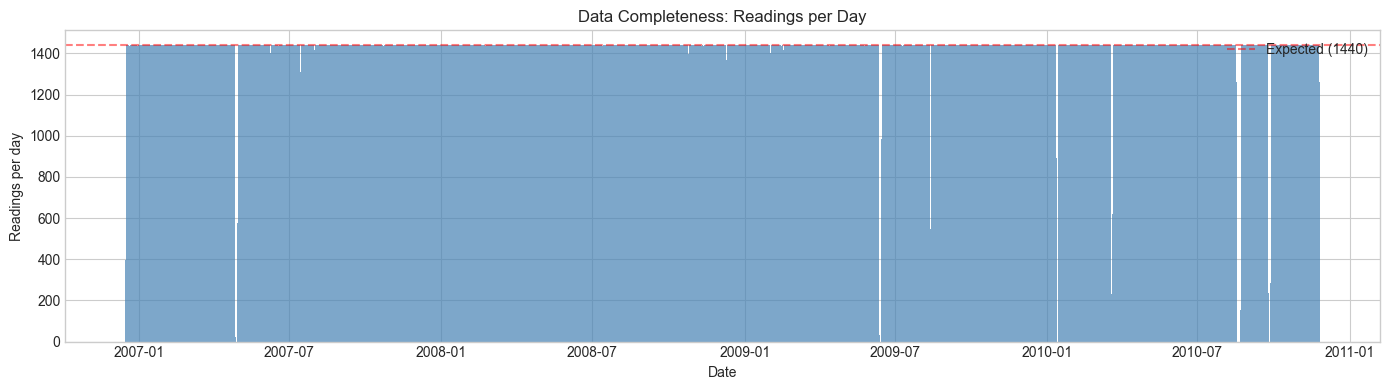

Days with missing data: 84 / 1442 (5.8%)


In [11]:
# Visualise missing data pattern across the full date range
# Resample to daily counts — days with < 1440 rows have missing data
daily_counts = df.resample("D").size()
expected_per_day = 1440  # 24 * 60

fig, ax = plt.subplots(figsize=(14, 4))
ax.bar(daily_counts.index, daily_counts.values, width=1, color="steelblue", alpha=0.7)
ax.axhline(y=expected_per_day, color="red", linestyle="--", alpha=0.5, label=f"Expected ({expected_per_day})")
ax.set_xlabel("Date")
ax.set_ylabel("Readings per day")
ax.set_title("Data Completeness: Readings per Day")
ax.legend()
plt.tight_layout()
plt.show()

# Quantify
incomplete_days = (daily_counts < expected_per_day).sum()
total_days = len(daily_counts)
print(f"Days with missing data: {incomplete_days} / {total_days} ({100*incomplete_days/total_days:.1f}%)")

## 4. Daily Consumption Patterns

How does energy usage vary throughout the day? This is critical for
feature engineering later — hour-of-day will be a key feature.

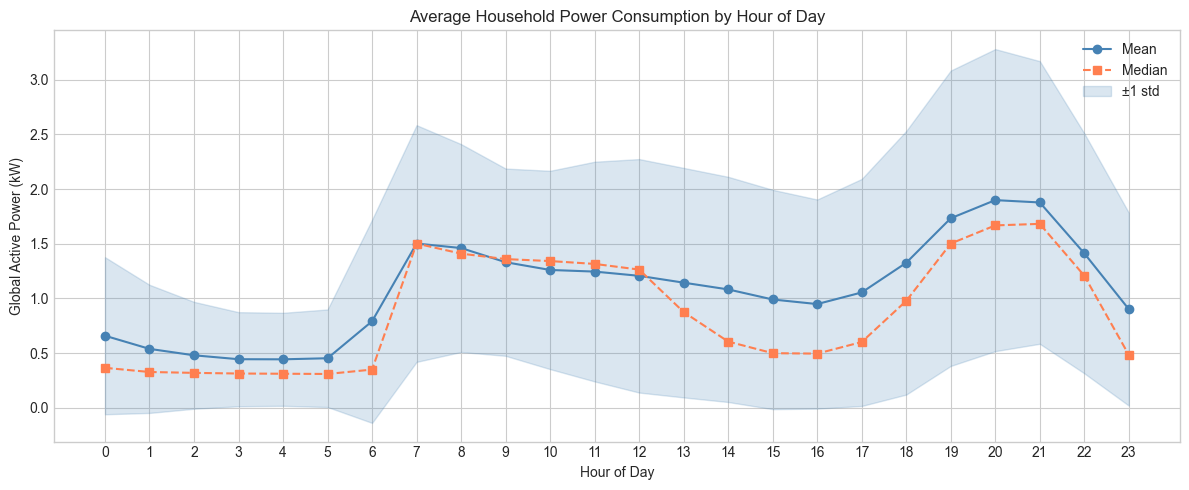

In [12]:
# Average consumption by hour of day
hourly = df.groupby(df.index.hour)["global_active_power_kw"].agg(["mean", "std", "median"])
hourly.columns = ["mean_kw", "std_kw", "median_kw"]

fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(hourly.index, hourly["mean_kw"], "o-", color="steelblue", label="Mean")
ax.plot(hourly.index, hourly["median_kw"], "s--", color="coral", label="Median")
ax.fill_between(
    hourly.index,
    hourly["mean_kw"] - hourly["std_kw"],
    hourly["mean_kw"] + hourly["std_kw"],
    alpha=0.2,
    color="steelblue",
    label="±1 std",
)
ax.set_xlabel("Hour of Day")
ax.set_ylabel("Global Active Power (kW)")
ax.set_title("Average Household Power Consumption by Hour of Day")
ax.set_xticks(range(24))
ax.legend()
plt.tight_layout()
plt.show()

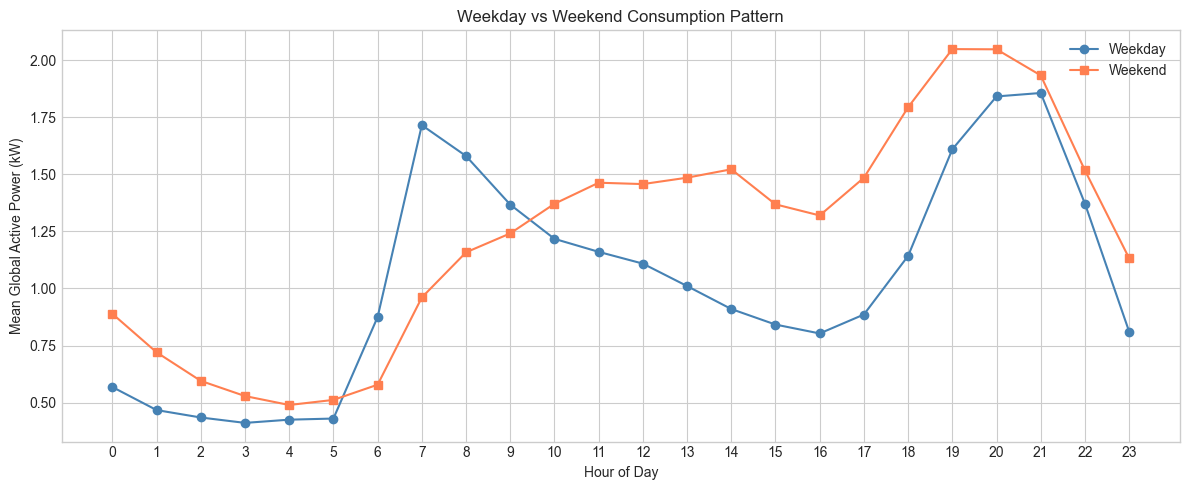

In [13]:
# Weekday vs Weekend comparison
df["hour"] = df.index.hour
df["is_weekend"] = df.index.dayofweek >= 5

weekday_hourly = df[~df["is_weekend"]].groupby("hour")["global_active_power_kw"].mean()
weekend_hourly = df[df["is_weekend"]].groupby("hour")["global_active_power_kw"].mean()

fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(weekday_hourly.index, weekday_hourly.values, "o-", label="Weekday", color="steelblue")
ax.plot(weekend_hourly.index, weekend_hourly.values, "s-", label="Weekend", color="coral")
ax.set_xlabel("Hour of Day")
ax.set_ylabel("Mean Global Active Power (kW)")
ax.set_title("Weekday vs Weekend Consumption Pattern")
ax.set_xticks(range(24))
ax.legend()
plt.tight_layout()
plt.show()

## 5. Weekly and Monthly Trends

Longer-term patterns — seasonal variation and weekly cycles.

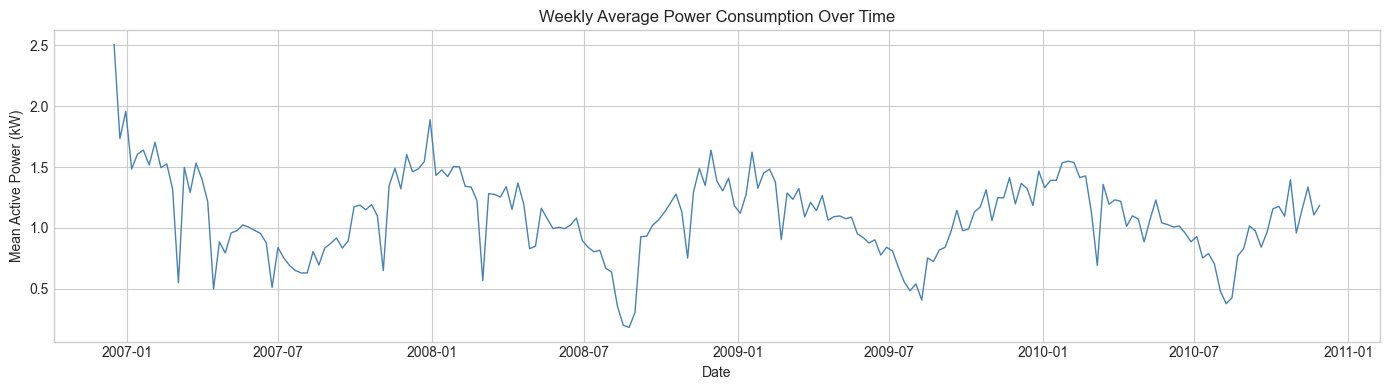

In [14]:
# Weekly average consumption
weekly = df["global_active_power_kw"].resample("W").mean()

fig, ax = plt.subplots(figsize=(14, 4))
ax.plot(weekly.index, weekly.values, color="steelblue", linewidth=1)
ax.set_xlabel("Date")
ax.set_ylabel("Mean Active Power (kW)")
ax.set_title("Weekly Average Power Consumption Over Time")
plt.tight_layout()
plt.show()

C:\Users\babatundea\AppData\Local\Temp\ipykernel_6228\3302511601.py:6: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(monthly_data, labels=[


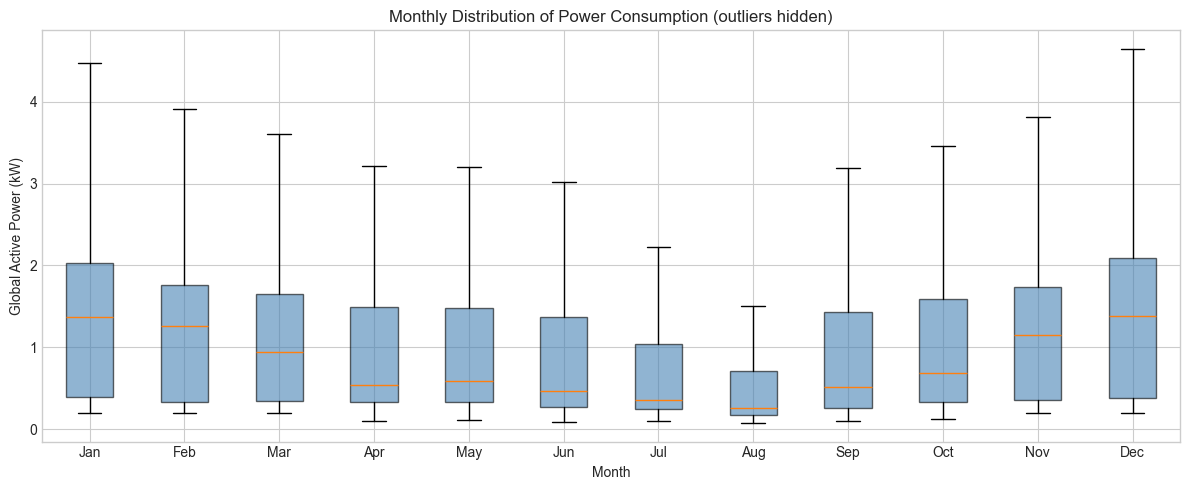

In [15]:
# Monthly boxplot — shows seasonal variation + spread
df["month"] = df.index.month
monthly_data = [df[df["month"] == m]["global_active_power_kw"].values for m in range(1, 13)]

fig, ax = plt.subplots(figsize=(12, 5))
bp = ax.boxplot(monthly_data, labels=[
    "Jan", "Feb", "Mar", "Apr", "May", "Jun",
    "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"
], patch_artist=True, showfliers=False)
for patch in bp["boxes"]:
    patch.set_facecolor("steelblue")
    patch.set_alpha(0.6)
ax.set_xlabel("Month")
ax.set_ylabel("Global Active Power (kW)")
ax.set_title("Monthly Distribution of Power Consumption (outliers hidden)")
plt.tight_layout()
plt.show()

## 6. Distributions of Key Metrics

Understanding the shape of each variable helps choose appropriate
models and detect obvious issues.

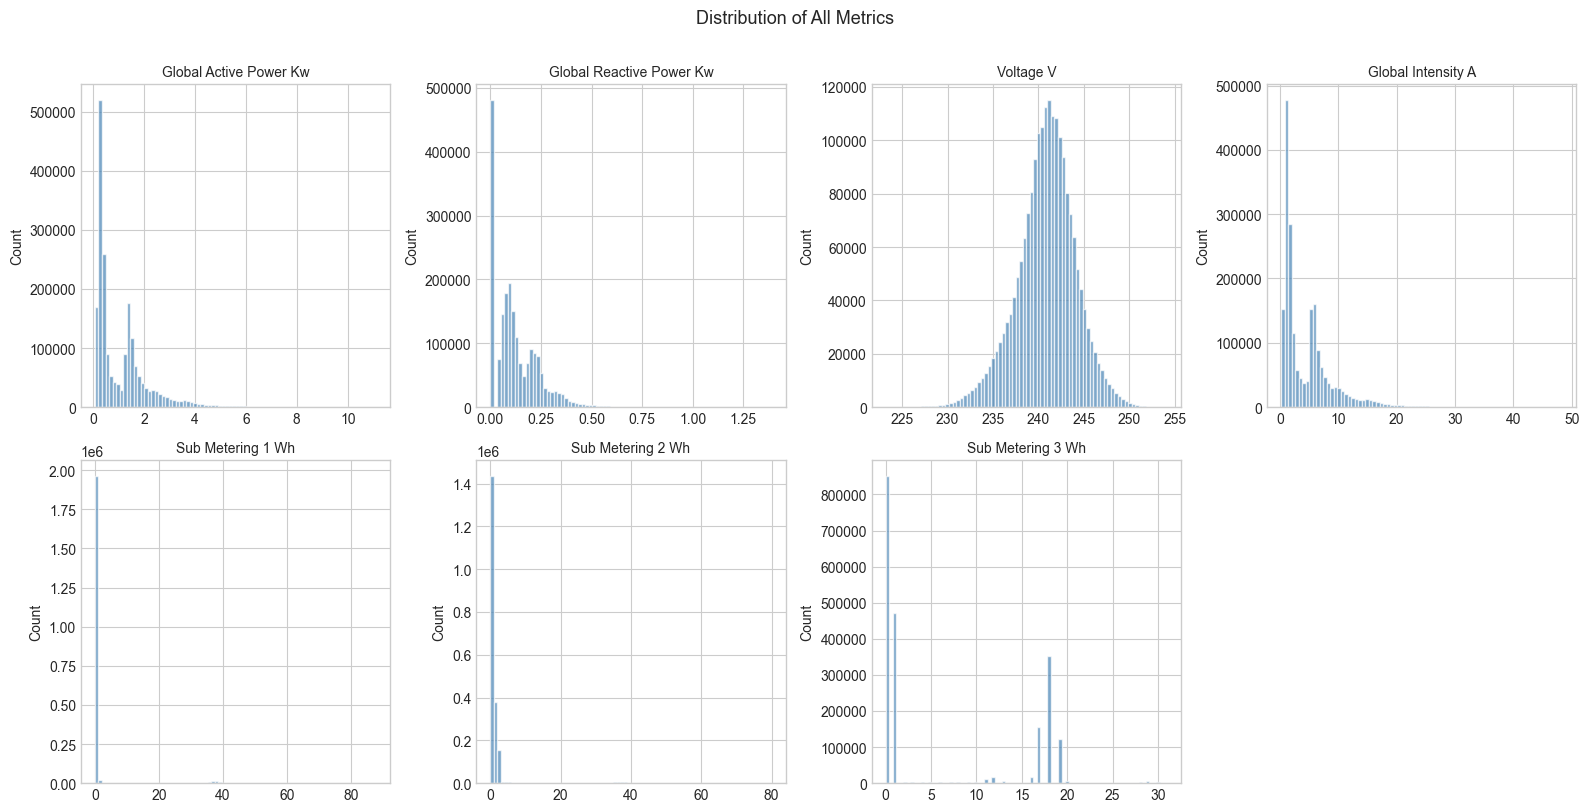

In [16]:
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

columns = [
    "global_active_power_kw",
    "global_reactive_power_kw",
    "voltage_v",
    "global_intensity_a",
    "sub_metering_1_wh",
    "sub_metering_2_wh",
    "sub_metering_3_wh",
]

for i, col in enumerate(columns):
    axes[i].hist(df[col].dropna(), bins=80, color="steelblue", alpha=0.7, edgecolor="white")
    axes[i].set_title(col.replace("_", " ").title(), fontsize=10)
    axes[i].set_ylabel("Count")

# Hide unused subplot
axes[7].set_visible(False)

plt.suptitle("Distribution of All Metrics", fontsize=13, y=1.01)
plt.tight_layout()
plt.show()

## 7. Correlation Analysis

How do the variables relate to each other? Strong correlations tell us
which features carry redundant information.

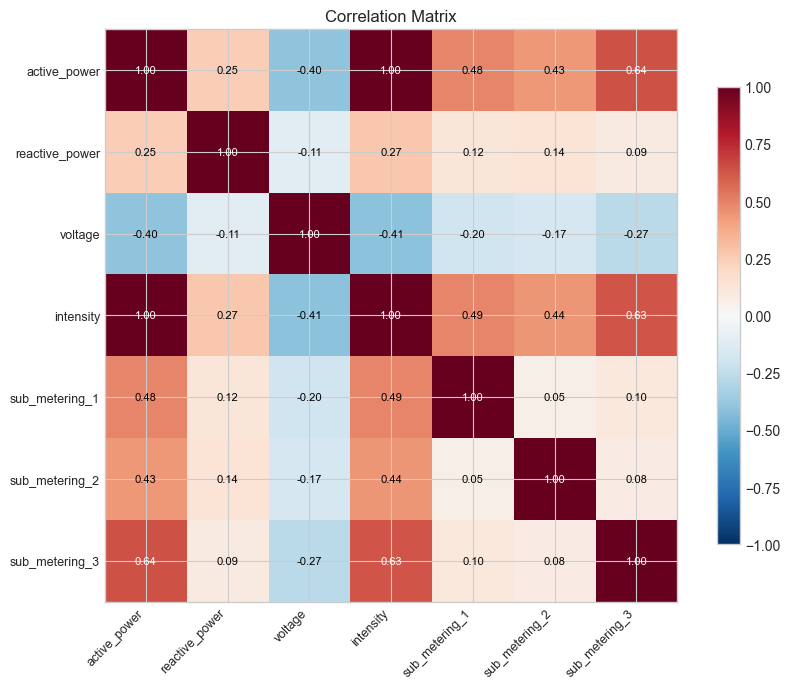

In [17]:
corr = df[columns].corr()

fig, ax = plt.subplots(figsize=(9, 7))
im = ax.imshow(corr, cmap="RdBu_r", vmin=-1, vmax=1)

# Labels
short_labels = [c.replace("global_", "").replace("_kw", "").replace("_wh", "").replace("_v", "").replace("_a", "")
                for c in columns]
ax.set_xticks(range(len(columns)))
ax.set_yticks(range(len(columns)))
ax.set_xticklabels(short_labels, rotation=45, ha="right", fontsize=9)
ax.set_yticklabels(short_labels, fontsize=9)

# Annotate
for i in range(len(columns)):
    for j in range(len(columns)):
        ax.text(j, i, f"{corr.iloc[i, j]:.2f}", ha="center", va="center", fontsize=8,
                color="white" if abs(corr.iloc[i, j]) > 0.5 else "black")

plt.colorbar(im, ax=ax, shrink=0.8)
ax.set_title("Correlation Matrix")
plt.tight_layout()
plt.show()

### Interpretation

After running the correlation matrix, note:
- **Active power ↔ Intensity**: Expected to be very high (P ≈ V × I).
- **Sub-meters vs total**: How much of total consumption do the 3 sub-meters capture?
- **Voltage**: Typically low correlation with power (supply-side, not demand-side).

Document your findings here.

## 8. Sub-Metering Analysis

The dataset has 3 sub-meters:
- **Sub 1**: Kitchen (dishwasher, oven, microwave)
- **Sub 2**: Laundry (washing machine, dryer, fridge, light)
- **Sub 3**: Water heater + air conditioning

The remainder (total - sub1 - sub2 - sub3) is unmetered consumption.

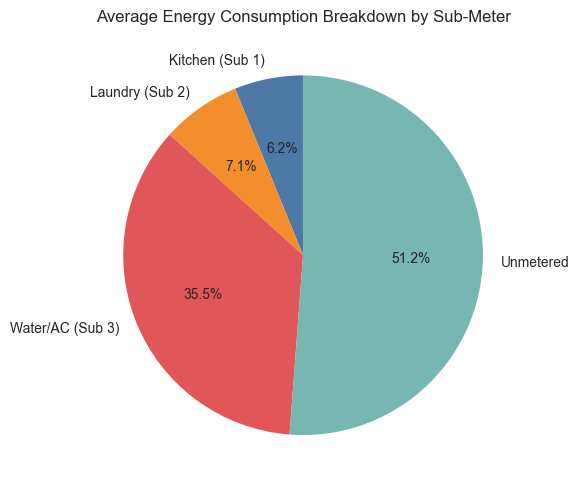

  Kitchen (Sub 1): 1.12 Wh/min
  Laundry (Sub 2): 1.30 Wh/min
  Water/AC (Sub 3): 6.46 Wh/min
  Unmetered: 9.31 Wh/min


In [18]:
# Calculate unmetered consumption (in Wh per minute)
# global_active_power is in kW, sub_meterings are in Wh per minute
# Convert: kW * 1000/60 = Wh/minute
df["total_wh_per_min"] = df["global_active_power_kw"] * 1000 / 60
df["unmetered_wh"] = (
    df["total_wh_per_min"]
    - df["sub_metering_1_wh"]
    - df["sub_metering_2_wh"]
    - df["sub_metering_3_wh"]
).clip(lower=0)

# Average share of each sub-meter
shares = {
    "Kitchen (Sub 1)": df["sub_metering_1_wh"].mean(),
    "Laundry (Sub 2)": df["sub_metering_2_wh"].mean(),
    "Water/AC (Sub 3)": df["sub_metering_3_wh"].mean(),
    "Unmetered": df["unmetered_wh"].mean(),
}

fig, ax = plt.subplots(figsize=(8, 5))
colors = ["#4e79a7", "#f28e2b", "#e15759", "#76b7b2"]
ax.pie(shares.values(), labels=shares.keys(), autopct="%1.1f%%", colors=colors, startangle=90)
ax.set_title("Average Energy Consumption Breakdown by Sub-Meter")
plt.tight_layout()
plt.show()

for name, val in shares.items():
    print(f"  {name}: {val:.2f} Wh/min")

## 9. Identifying Natural Anomalies

Before we build ML models, we need to understand what anomalies look like
in this data. We'll use simple statistical methods to flag potential anomalies,
then manually review them to build a labelled evaluation set.

**Approach**: Flag readings where `global_active_power_kw` exceeds the
99th percentile or drops to near-zero during normally active hours.

In [19]:
# Statistical thresholds
p99 = df["global_active_power_kw"].quantile(0.99)
p01 = df["global_active_power_kw"].quantile(0.01)
print(f"99th percentile: {p99:.3f} kW")
print(f" 1st percentile: {p01:.3f} kW")

# Flag anomalies: high spikes
high_spikes = df[df["global_active_power_kw"] > p99]
print(f"\nHigh spike readings (>p99): {len(high_spikes):,}")

# Flag anomalies: near-zero during active hours (8am-10pm)
active_hours = df[(df.index.hour >= 8) & (df.index.hour <= 22)]
low_dropouts = active_hours[active_hours["global_active_power_kw"] < p01]
print(f"Low dropout readings during active hours (<p01): {len(low_dropouts):,}")

99th percentile: 4.850 kW
 1st percentile: 0.110 kW

High spike readings (>p99): 20,473
Low dropout readings during active hours (<p01): 11,069


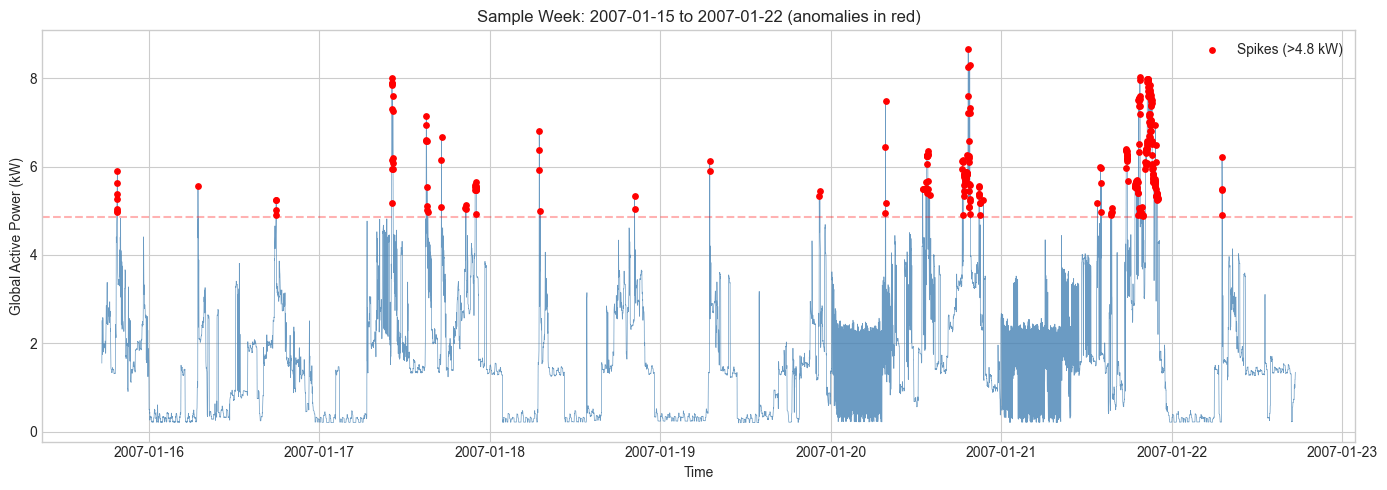

In [20]:
# Visualise a sample week with anomalies highlighted
sample_start = df.index.min() + pd.Timedelta(days=30)
sample_end = sample_start + pd.Timedelta(days=7)
sample = df.loc[sample_start:sample_end, "global_active_power_kw"]

fig, ax = plt.subplots(figsize=(14, 5))
ax.plot(sample.index, sample.values, color="steelblue", linewidth=0.5, alpha=0.8)

# Overlay spikes
spike_mask = sample > p99
if spike_mask.any():
    ax.scatter(sample.index[spike_mask], sample.values[spike_mask],
               color="red", s=15, zorder=5, label=f"Spikes (>{p99:.1f} kW)")

ax.axhline(y=p99, color="red", linestyle="--", alpha=0.3)
ax.set_xlabel("Time")
ax.set_ylabel("Global Active Power (kW)")
ax.set_title(f"Sample Week: {sample_start.date()} to {sample_end.date()} (anomalies in red)")
ax.legend()
plt.tight_layout()
plt.show()

## 10. Summary & Next Steps

### Key Findings
*Fill in after running all cells:*
1. **Data shape**: ___ rows, ___ columns, spanning ___ to ___
2. **Missing data**: ___% of expected readings absent
3. **Daily pattern**: Peak consumption at ___am and ___pm
4. **Seasonal pattern**: Higher consumption in ___ months
5. **Sub-metering**: Unmetered consumption accounts for ___% of total
6. **Correlations**: Active power strongly correlates with ___
7. **Anomaly candidates**: ___ high spikes, ___ low dropouts identified

### Next Steps
- **Notebook 01**: Deeper exploration of seasonal patterns and sub-meter behaviour
- **Notebook 02**: Feature engineering — build the feature pipeline
- **Manual labelling**: Export anomaly candidates to `data/processed/anomaly_labels.csv`

In [21]:
# Drop temporary columns
df.drop(columns=["hour", "is_weekend", "total_wh_per_min", "unmetered_wh"],
        inplace=True, errors="ignore")
print("Notebook complete.")

Notebook complete.
